# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import sys
sys.path.append('../SEIR_full/')
sys.path.append('..')
import SEIR_full as mdl
import datetime as dt
from scipy.stats import poisson
from scipy.stats import binom

# Model run

In [2]:

model = mdl.Model_behave(
    beta_j=np.array([0.02927922 ,0.02927922 ,0.02927922 ,0.04655266,0.04655266,0.05775265,0.05775265,0.18444245,0.18444245]),
    theta=2.826729434860104,
    beta_behave=0.5552998605894367,
    eps=mdl.eps_sector['Scenario2'],
    f=mdl.f0_full['Scenario2'],
)

res_mdl = model.predict(
    C=mdl.C_calibration,
    days_in_season=200,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

model.reset()

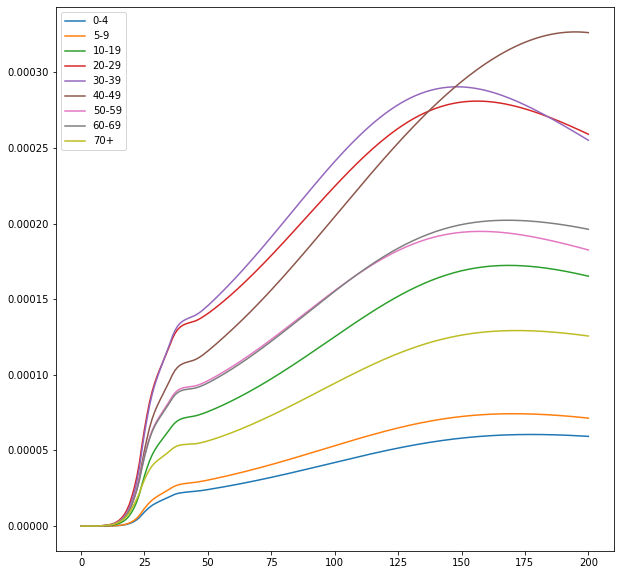

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x9a34f28>)

In [3]:
mdl.plot_I_by_age(res_mdl)

# Model Calibration

In [4]:
first = pd.Timestamp('2020-03-20')
last = pd.Timestamp('2020-04-13')

## Data

In [5]:
tot = pd.read_csv('../Data/sick/all_tests_by_age_county.csv')
pos = pd.read_csv('../Data/sick/smooth_sick_by_age_county.csv')

In [6]:
tot.drop('age_unknown', axis=1, inplace=True)
tot.set_index('test_date', inplace=True)
tot.columns = ['county'] + list(mdl.A.values())
tot.sort_values(by='county', inplace=True)
tot = tot.pivot(columns='county')
tot.columns = tot.columns.swaplevel(0, 1)
tot = tot.reindex(pd.MultiIndex.from_product([mdl.G.values(), mdl.A.values()]), axis=1)
tot.index = pd.to_datetime(tot.index)
tot = tot.reindex(pd.date_range(tot.index.values.min(), tot.index.values.max(),freq='d'), fill_value=0)
tot.fillna(0, inplace=True)

In [7]:
pos.drop('age_unknown', axis=1, inplace=True)
pos.set_index('Unnamed: 1', inplace=True)
pos.columns = ['county'] + list(mdl.A.values())
pos.sort_values(by='county', inplace=True)
pos = pos.pivot(columns='county')
pos.columns = pos.columns.swaplevel(0, 1)
pos = pos.reindex(pd.MultiIndex.from_product([mdl.G.values(), mdl.A.values()]), axis=1)
pos.index = pd.to_datetime(pos.index)
pos = pos.reindex(pd.date_range(pos.index.values.min(), pos.index.values.max(),freq='d'), fill_value=0)
pos.fillna(0, inplace=True)

In [8]:
begining = min([pos.index.values.min(), tot.index.values.min()])
ending = max([pos.index.values.max(), tot.index.values.max()])
pos = pos.reindex(pd.date_range(begining, ending,freq='d'), fill_value=0)
tot = tot.reindex(pd.date_range(begining, ending,freq='d'), fill_value=0)

## Data old

In [9]:
# data = pd.read_csv('../Data/sick/old_data2003_1304.csv', index_col=0)
# data.head()

## Scenario 2

In [10]:
# fit params
days_in_season=70
date_lst = pd.date_range('2020-02-20',last)
len(date_lst)

54

In [14]:
# Model Fitting
p0=(0.03574392,0.0680812,0.07149694,0.24919698,1.8512674898217287, 0.40194272460656777) # initial guess
bnds = ((0,0.1),(0,0.15),(0,0.15),(0,0.3),(1.5,3),(0,0.6))# boundries for variables
res_fit = []
hyper_param = []
######## Doind Exp:
######## checking shift, different losses, and factors:
for i, (factor, shift, loss) in enumerate(itertools.product(
    [1 ,10 ,100, 500, 1000],
    np.arange(-7, 7, 1),
    ['MSE', 'BIN', 'POIS', 'POIS_NAIV'],
)):
    if (loss not in ['BIN', 'POIS']) and (factor != 1):
        continue
    hyper_param.append((factor, shift, loss))
    print('Checking combination: ', (factor, shift, loss))
    #defining shift
    pos_shift = pos.copy()
    tot_shift = tot.copy()
    pos_shift.index = pd.DatetimeIndex(pos.index + pd.DateOffset(shift))
    tot_shift.index = pd.DatetimeIndex(tot.index + pd.DateOffset(shift))
    pos_shift.index = pd.to_datetime(pos_shift.index)
    tot_shift.index = pd.to_datetime(tot_shift.index)
    min_d = max([pos_shift.index.values.min(), first])
    max_d = min([pos_shift.index.values.max(), last])
    pos_shift = pos_shift.loc[pd.date_range(min_d,max_d)]
    tot_shift = tot_shift.loc[pd.date_range(min_d,max_d)]
    
    data = np.ndarray((2,len(pos_shift), len(mdl.GA.values())))
    data[0] = tot_shift
    data[1] = pos_shift
    
    res_fit.append(model.fit(
        p0=p0,
        bnds=bnds,
        data=data,
        date_lst = date_lst,
        days_in_season=days_in_season,
        start=min_d,
        end=max_d,
        loss_func=loss,
        maxiter=300,
        factor=factor,
    ))
    # errorfunc(tpl,data,f,season_length, eps, alpha)
                        
# print data stat
mdl.print_stat_fit_behave(res_fit)


Checking combination:  (1, -7, 'MSE')
iter:  50  loss:  -24.417526001936896
iter:  100  loss:  -24.78465318081429
iter:  150  loss:  -24.7954446019401
iter:  200  loss:  -24.801256059212246
iter:  250  loss:  -24.81054238018346
iter:  300  loss:  -24.813893869109652
iter:  350  loss:  -24.81374899234063
iter:  400  loss:  -24.80498127858645
iter:  450  loss:  -24.82470429278541
iter:  500  loss:  -24.83891551209897
iter:  550  loss:  -24.862248715150766
iter:  600  loss:  -24.863088816161365
iter:  650  loss:  -24.866384607423225
iter:  700  loss:  -24.873871583541952
iter:  750  loss:  -24.874842697688077
iter:  800  loss:  -24.875149240235583
iter:  850  loss:  -24.871953384999824
iter:  900  loss:  -24.876064627134763
iter:  950  loss:  -24.876066889522928
iter:  1000  loss:  -24.875985379108048
iter:  1050  loss:  -24.876073731518037
iter:  1100  loss:  -24.87603753172038
iter:  1150  loss:  -24.87611102012352
iter:  1200  loss:  -24.87609854878217
iter:  1250  loss:  -24.876114833

..\SEIR_full\model_class.py:260: RuntimeWarning: divide by zero encountered in true_divide
  data_specific[1] = (data_specific[1] / data_specific[0])
..\SEIR_full\model_class.py:260: RuntimeWarning: invalid value encountered in true_divide
  data_specific[1] = (data_specific[1] / data_specific[0])


iter:  50  loss:  8090.611627403676
iter:  100  loss:  6096.220049004725
iter:  150  loss:  6460.336281519256
iter:  200  loss:  5936.578236749507
iter:  250  loss:  5936.499145910712
iter:  300  loss:  5936.502583362342
iter:  350  loss:  5936.498162804499
iter:  400  loss:  5936.498102881672
Checking combination:  (1, -7, 'POIS')


..\SEIR_full\model_class.py:275: RuntimeWarning: divide by zero encountered in true_divide
  data_specific[1] = (data_specific[1] / data_specific[0])
..\SEIR_full\model_class.py:275: RuntimeWarning: invalid value encountered in true_divide
  data_specific[1] = (data_specific[1] / data_specific[0])


iter:  50  loss:  8067.33293550381
iter:  100  loss:  6118.288962168184
iter:  150  loss:  5696.727835843092
Checking combination:  (1, -7, 'POIS_NAIV')
iter:  50  loss:  2357.5346492285744
iter:  100  loss:  2305.958783939821
iter:  150  loss:  2225.86059930772
iter:  200  loss:  2212.3463910997693
iter:  250  loss:  2184.2237958241512
iter:  300  loss:  2165.927480149525
iter:  350  loss:  2162.710836059174
iter:  400  loss:  2161.544343571647
iter:  450  loss:  2161.2321499899663
iter:  500  loss:  2161.2259923410024
iter:  550  loss:  2161.227504340477
iter:  600  loss:  2161.203239212906
iter:  650  loss:  2161.3980242659577
iter:  700  loss:  2161.036645021921
iter:  750  loss:  2160.5437973801395
iter:  800  loss:  2160.4535574302304
iter:  850  loss:  2160.0650889481303
iter:  900  loss:  2159.9254451058787
iter:  950  loss:  2159.8882176043962
iter:  1000  loss:  2159.8758412903617
iter:  1050  loss:  2160.6953772392544
iter:  1100  loss:  2159.875540811772
iter:  1150  loss: 

iter:  1750  loss:  -24.82488555446381
iter:  1800  loss:  -24.824981202432003
iter:  1850  loss:  -24.821480345734027
iter:  1900  loss:  -24.825167894711804
iter:  1950  loss:  -24.825199772006393
iter:  2000  loss:  -24.82521998413945
iter:  2050  loss:  -24.824955899393014
iter:  2100  loss:  -24.825296191732917
iter:  2150  loss:  -24.825371703864036
iter:  2200  loss:  -24.82522366398175
iter:  2250  loss:  -24.823484937293053
iter:  2300  loss:  -24.82574695537985
iter:  2350  loss:  -24.826027658569515
iter:  2400  loss:  -24.08598215602626
Checking combination:  (1, -4, 'BIN')
iter:  50  loss:  8370.188967680775
iter:  100  loss:  6966.661760244973
iter:  150  loss:  6498.298197853033
Checking combination:  (1, -4, 'POIS')
iter:  50  loss:  12639.188312277423
iter:  100  loss:  6903.897681540844
iter:  150  loss:  6401.414565722129
Checking combination:  (1, -4, 'POIS_NAIV')
iter:  50  loss:  2748.101428645545
iter:  100  loss:  2613.1249597094506
iter:  150  loss:  2594.06494

iter:  1000  loss:  2779.63222300299
iter:  1050  loss:  2779.512423990057
iter:  1100  loss:  2784.6802423513814
iter:  1150  loss:  2778.868923237339
iter:  1200  loss:  2778.7668845218086
iter:  1250  loss:  2778.466178557281
iter:  1300  loss:  2777.4358662786453
iter:  1350  loss:  2777.2972752977266
iter:  1400  loss:  2777.0785842673267
iter:  1450  loss:  2778.742606502665
iter:  1500  loss:  2776.9147266068658
iter:  1550  loss:  2776.435759448598
iter:  1600  loss:  2775.5394319208435
iter:  1650  loss:  2775.5230065159203
iter:  1700  loss:  2775.64217303995
iter:  1750  loss:  2775.4867014209776
iter:  1800  loss:  2775.4654036929483
iter:  1850  loss:  2775.4650478570456
iter:  1900  loss:  2775.4649821123685
iter:  1950  loss:  2775.4649781287694
iter:  2000  loss:  2775.4649714903617
iter:  2050  loss:  2775.46496754412
iter:  2100  loss:  2775.4649698261073
iter:  2150  loss:  2775.464962774638
iter:  2200  loss:  2775.4649612134717
iter:  2250  loss:  2775.464959149134

iter:  1400  loss:  -24.726012264403387
iter:  1450  loss:  -24.726013248919124
iter:  1500  loss:  -24.726015107682926
iter:  1550  loss:  -24.72601939863685
iter:  1600  loss:  -24.725995324756223
iter:  1650  loss:  -24.726023711248192
iter:  1700  loss:  -24.726024423043548
iter:  1750  loss:  -24.72602444231351
iter:  1800  loss:  -24.726024549175282
iter:  1850  loss:  -24.72601351065821
iter:  1900  loss:  -24.72602699037709
iter:  1950  loss:  -24.726027090951895
iter:  2000  loss:  -24.7260250930868
Checking combination:  (1, 1, 'BIN')
iter:  50  loss:  12528.376966529653
iter:  100  loss:  8691.674278865852
iter:  150  loss:  7561.379913341671
Checking combination:  (1, 1, 'POIS')
iter:  50  loss:  10132.038754261312
iter:  100  loss:  9302.145117901386
iter:  150  loss:  8494.17573405601
Checking combination:  (1, 1, 'POIS_NAIV')
iter:  50  loss:  2812.3212298869125
iter:  100  loss:  2760.2622566665896
iter:  150  loss:  2752.6179547795628
iter:  200  loss:  2738.8004880638

iter:  2300  loss:  -24.704609925667256
iter:  2350  loss:  -24.704610042028378
iter:  2400  loss:  -24.704610041810234
Checking combination:  (1, 3, 'BIN')
iter:  50  loss:  13560.988329382906
iter:  100  loss:  8933.485694877432
iter:  150  loss:  8579.966214687025
iter:  200  loss:  7488.537181854752
Checking combination:  (1, 3, 'POIS')
iter:  50  loss:  11679.524615498116
iter:  100  loss:  10116.128577402644
iter:  150  loss:  8869.400260636921
iter:  200  loss:  7324.705670945414
Checking combination:  (1, 3, 'POIS_NAIV')
iter:  50  loss:  3124.461778024725
iter:  100  loss:  2778.8718008228743
iter:  150  loss:  2734.4990172277558
iter:  200  loss:  2717.001384508516
iter:  250  loss:  2710.887987170565
iter:  300  loss:  2710.594698916758
iter:  350  loss:  2709.177163858293
iter:  400  loss:  2708.7098791947765
iter:  450  loss:  2708.6867579613418
iter:  500  loss:  2708.672342951624
iter:  550  loss:  2708.699480454329
iter:  600  loss:  2708.6355195057076
iter:  650  loss:

iter:  2200  loss:  -24.697296524286486
iter:  2250  loss:  -24.693661063842665
iter:  2300  loss:  -24.69729944904158
iter:  2350  loss:  -24.697299602751958
iter:  2400  loss:  -24.69729776138759
Checking combination:  (1, 5, 'BIN')
iter:  50  loss:  10110.767815894586
iter:  100  loss:  7851.847039224025
iter:  150  loss:  7738.561351464272
Checking combination:  (1, 5, 'POIS')
iter:  50  loss:  9947.024153106631
iter:  100  loss:  8252.219394149113
iter:  150  loss:  8212.712620184937
Checking combination:  (1, 5, 'POIS_NAIV')
iter:  50  loss:  2879.3508411543335
iter:  100  loss:  2741.6484935325016
iter:  150  loss:  2735.6030412150158
iter:  200  loss:  2732.3060076813763
iter:  250  loss:  2731.6064786389966
iter:  300  loss:  2730.701551116558
iter:  350  loss:  2720.3111944385946
iter:  400  loss:  2719.1817664502096
iter:  450  loss:  2707.339330978487
iter:  500  loss:  2763.783267143403
iter:  550  loss:  2698.386729912016
iter:  600  loss:  2689.9741139366533
iter:  650  

iter:  50  loss:  60687.43354076952
iter:  100  loss:  52852.884020522244
iter:  150  loss:  50551.158856783004
Checking combination:  (10, 2, 'POIS')
iter:  50  loss:  15546.080411668558
iter:  100  loss:  9984.182927311243
iter:  150  loss:  7931.901850724161
Checking combination:  (10, 3, 'BIN')
iter:  50  loss:  56910.74721002163
iter:  100  loss:  50989.301318905156
iter:  150  loss:  49190.39383476641
Checking combination:  (10, 3, 'POIS')
iter:  50  loss:  11679.524615498116
iter:  100  loss:  10116.128577402644
iter:  150  loss:  8869.400260636921
iter:  200  loss:  7324.705670945414
Checking combination:  (10, 4, 'BIN')
iter:  50  loss:  61315.32955741394
iter:  100  loss:  50001.38371298241
iter:  150  loss:  47318.29786718768
Checking combination:  (10, 4, 'POIS')
iter:  50  loss:  9845.806446427654
iter:  100  loss:  7903.54852076372
iter:  150  loss:  7794.134039769164
Checking combination:  (10, 5, 'BIN')
iter:  50  loss:  54702.66438848959
iter:  100  loss:  44895.149771

iter:  100  loss:  8233.529013167528
iter:  150  loss:  7866.125624020718
Checking combination:  (500, 0, 'BIN')
iter:  50  loss:  0.004680463732075493
iter:  100  loss:  0.00047993426934680387
iter:  150  loss:  0.0003582179816560552
Checking combination:  (500, 0, 'POIS')
iter:  50  loss:  12336.959801113855
iter:  100  loss:  8732.182356618272
iter:  150  loss:  8385.709759087149
Checking combination:  (500, 1, 'BIN')
iter:  50  loss:  0.0040009639323165
iter:  100  loss:  0.0003580432962438022
iter:  150  loss:  0.0003185703858371313
Checking combination:  (500, 1, 'POIS')
iter:  50  loss:  10132.038754261312
iter:  100  loss:  9302.145117901386
iter:  150  loss:  8494.17573405601
Checking combination:  (500, 2, 'BIN')
iter:  50  loss:  0.003050117101978951
iter:  100  loss:  0.0005758653550089592
iter:  150  loss:  0.00022151255603078732
Checking combination:  (500, 2, 'POIS')
iter:  50  loss:  15546.080411668558
iter:  100  loss:  9984.182927311243
iter:  150  loss:  7931.9018507

AttributeError: 'list' object has no attribute 'fun'

In [13]:
# # last
# fitted_beta = [0.08401885, 0.0498636, 0.04742293, 0.29044575]
# fitted_beta = np.array([fitted_beta[0], fitted_beta[0], fitted_beta[0], 
#                    fitted_beta[1], fitted_beta[1], 
#                    fitted_beta[2], fitted_beta[2], 
#                    fitted_beta[3], fitted_beta[3]])
# theta = 1.7884756534064268
# beta_behave = 0.3114150965784499

In [14]:
# model.update({
#     'beta_j': fitted_beta,
#     'theta': theta,
#     'beta_behave': beta_behave,
# })

In [15]:
model.reset()
res_mdl = model.predict(
    C=mdl.C_calibration,
    days_in_season=200,
    stay_home_idx=mdl.stay_home_idx,
    not_routine=mdl.not_routine,
)

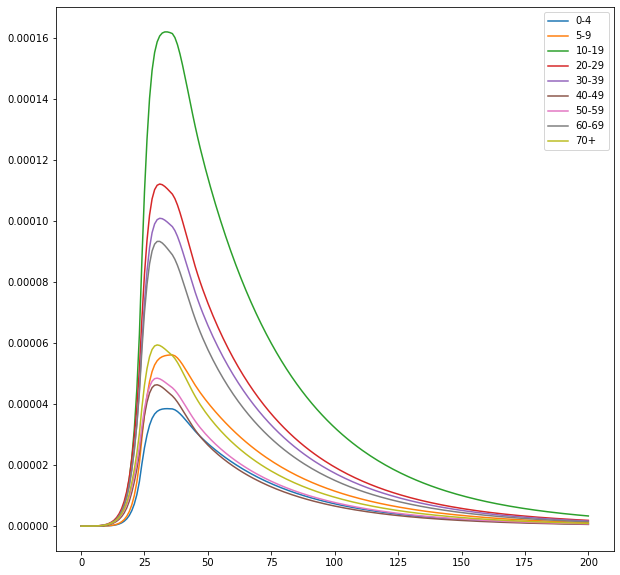

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x9b476a0>)

In [16]:
mdl.plot_I_by_age(res_mdl)

In [17]:
res_mdl['new_Is'].sum()

0.002522545709324517

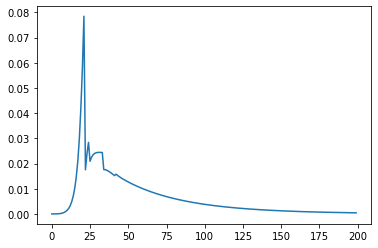

In [18]:
plt.plot((res_mdl['L'].sum(axis=1)))

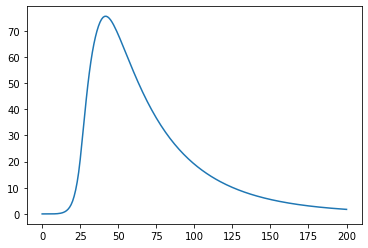

In [19]:
plt.plot((res_mdl['H'].sum(axis=1))*9136000)

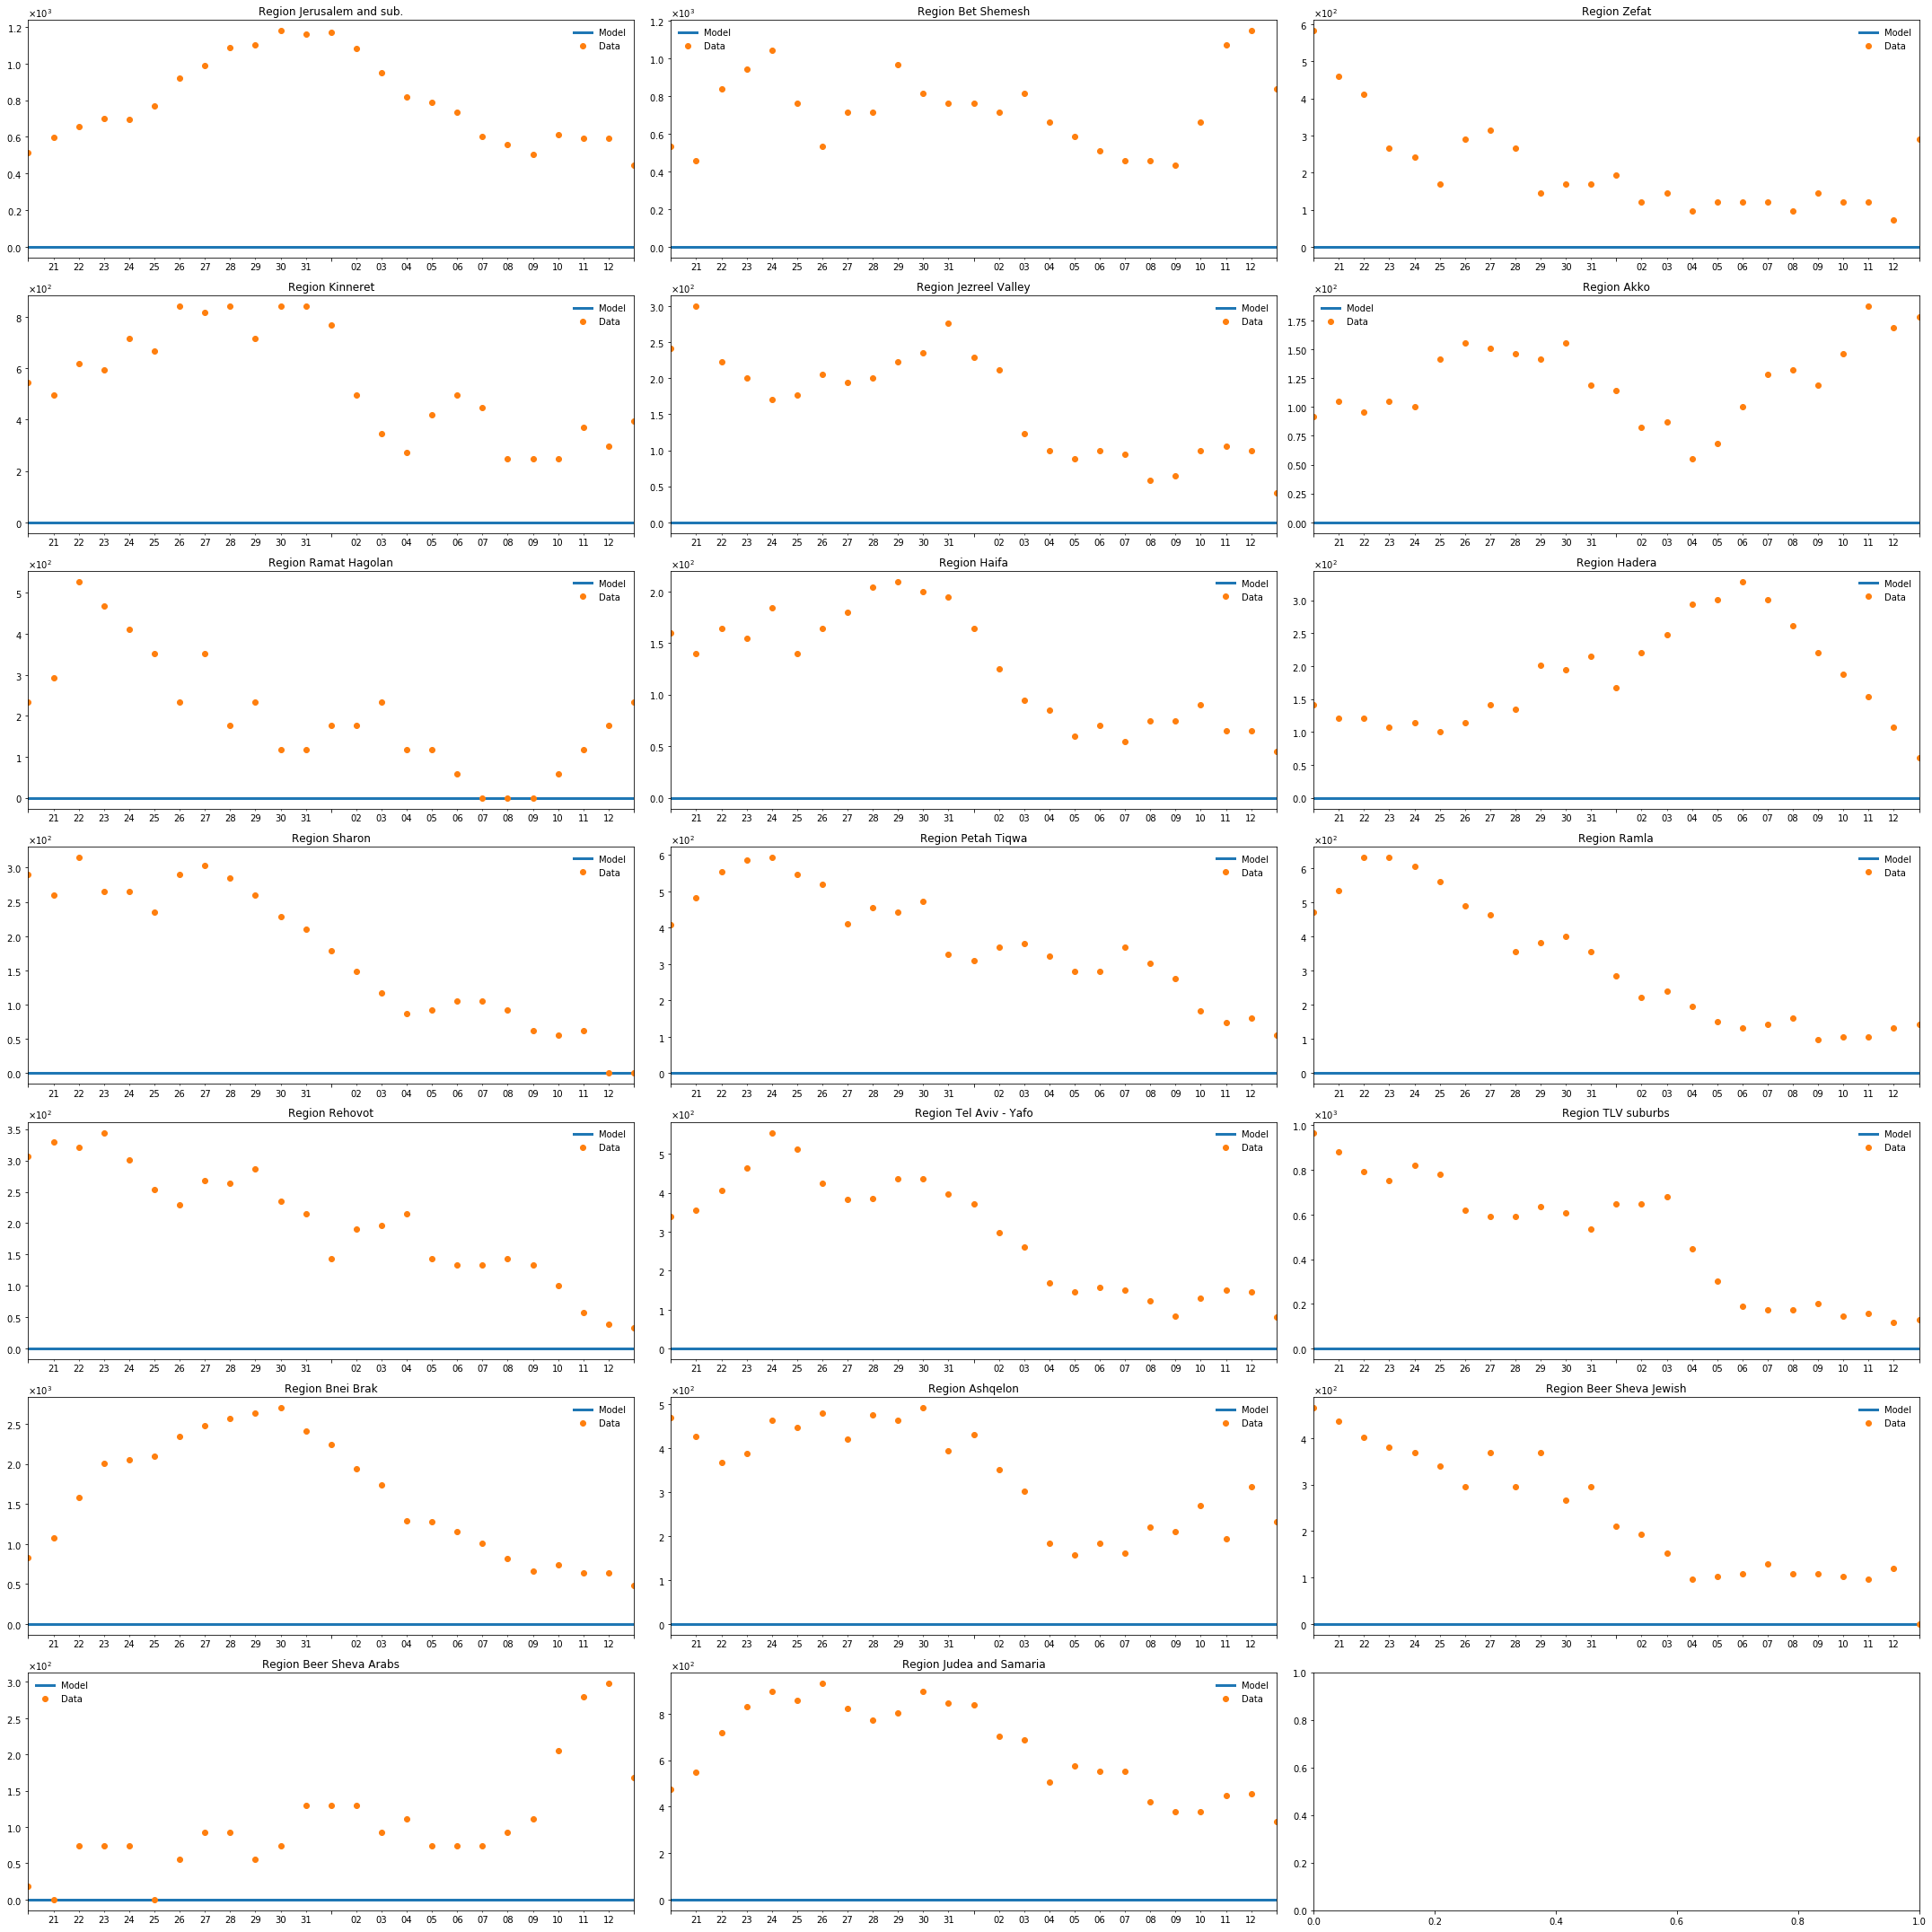

In [21]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=data, 
                                          mdl_data = res_mdl['new_Is'],
                                          date_list = date_lst,
                                          start=first,
                                          end=last,
                                          region_name = mdl.cell,
                                          loss_func = 'Pois_Naiv')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

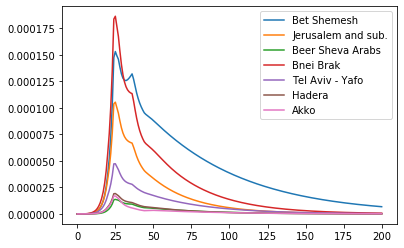

In [22]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.cell[region]] = (res_mdl['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

## old fit results

In [16]:
# best old fit results:
# alpha=1
# beta_j=np.array([0.02927922 ,0.02927922 ,0.02927922 ,0.04655266,0.04655266,0.05775265,0.05775265,0.18444245,0.18444245])
# theta=2.826729434860104
# beta_behave=0.5552998605894367
fitted_beta = [0.08401885, 0.0498636, 0.04742293, 0.29044575]
fitted_beta = np.array([beta_j[0], beta_j[0], beta_j[0], 
                   beta_j[1], beta_j[1], 
                   beta_j[2], beta_j[2], 
                   beta_j[3], beta_j[3]])
theta = 1.7884756534064268
beta_behave = 0.3114150965784499

In [3]:
res_mdl = mdl.run_sector_model_behave(beta_home=0.38/9., theta=theta, beta_j=beta_j, beta_behave=beta_behave,
                                        eps=mdl.eps_sector['Scenario2'], f=mdl.f0_full['Scenario2'], alpha=alpha, 
                                        days_in_season=175, nu=1/10.)

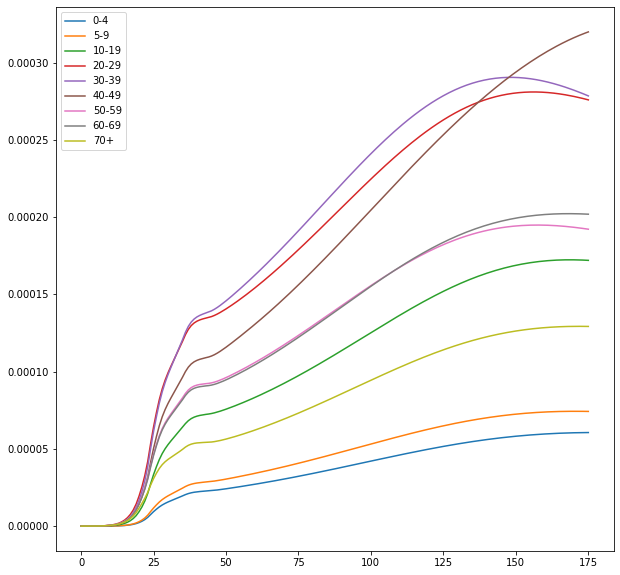

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x4cc2c50>)

In [4]:
mdl.plot_I_by_age(res_mdl)

In [5]:
res_mdl['new_Is'].sum()

0.014201607353994087

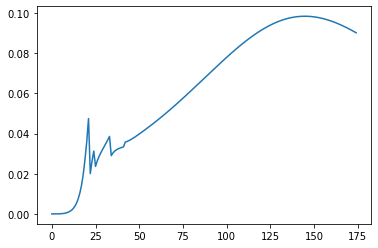

In [6]:
plt.plot((res_mdl['L'].sum(axis=1)))

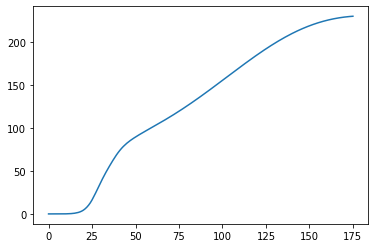

In [7]:
plt.plot((res_mdl['H'].sum(axis=1))*9136000)

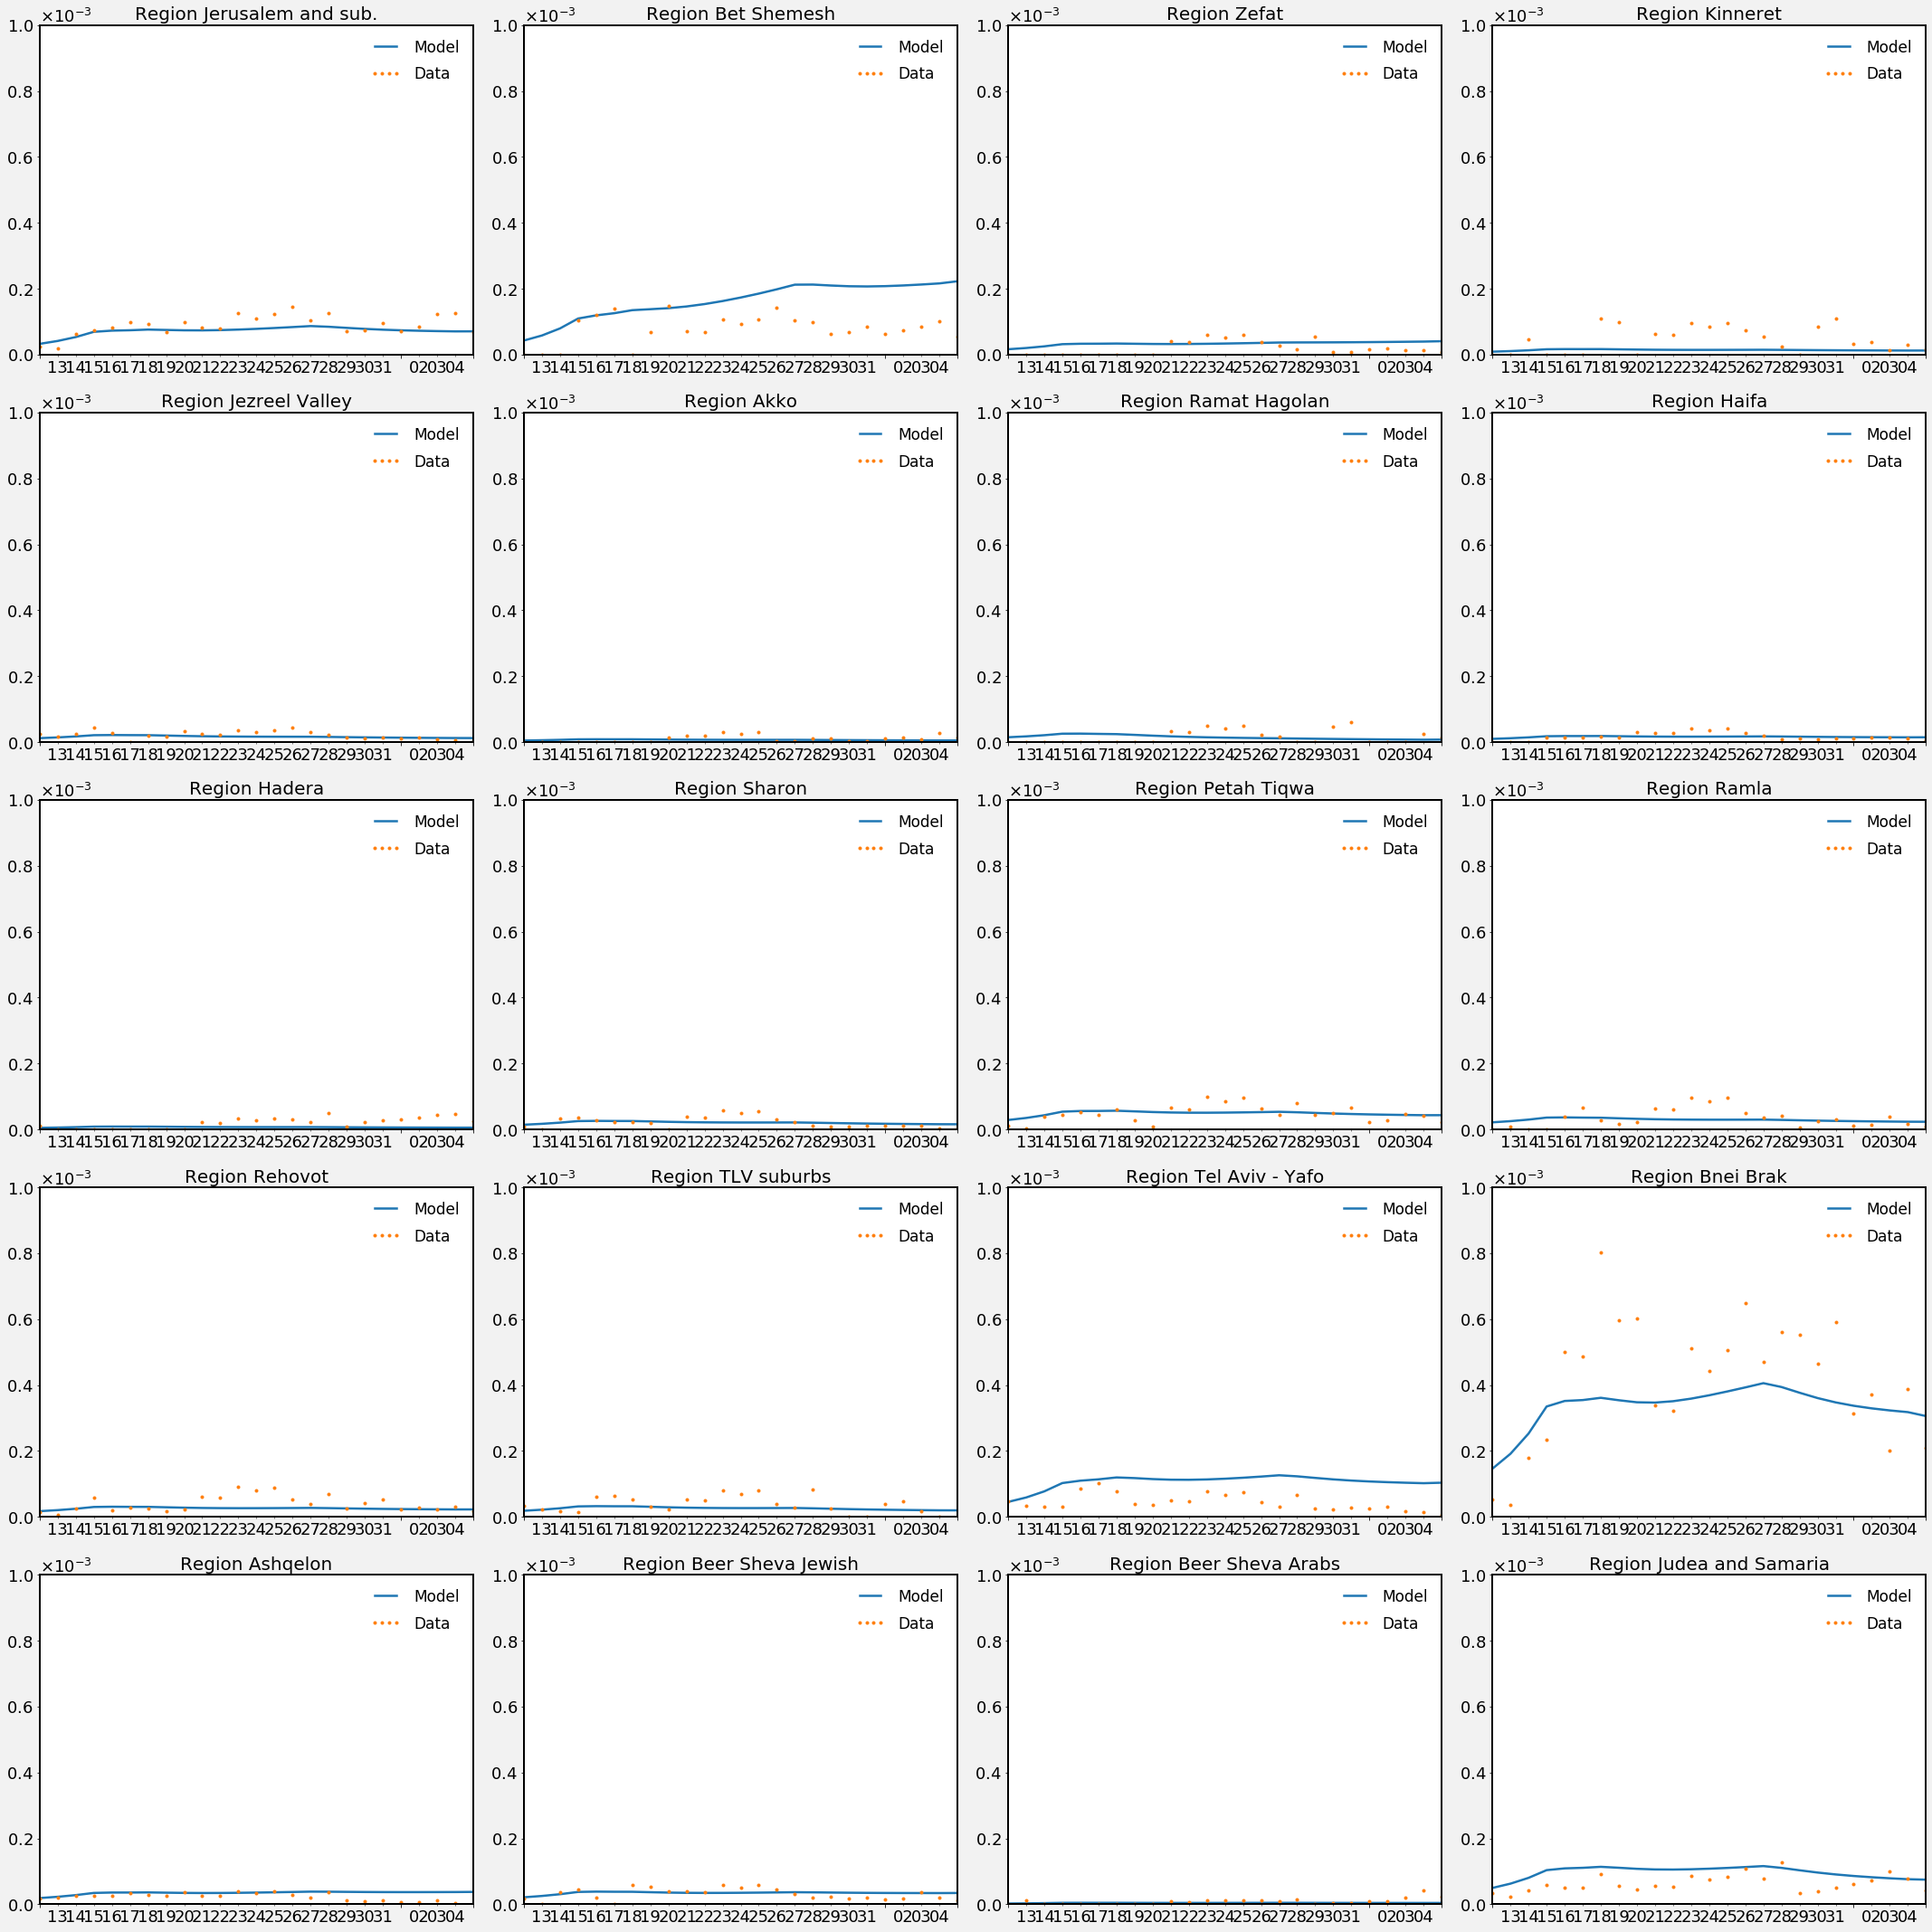

In [9]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=data.values, mdl_data = res_mdl['new_Is'],date_list = date_lst,
                                         start='2020-03-12',end='2020-04-05')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1434480fa20>)

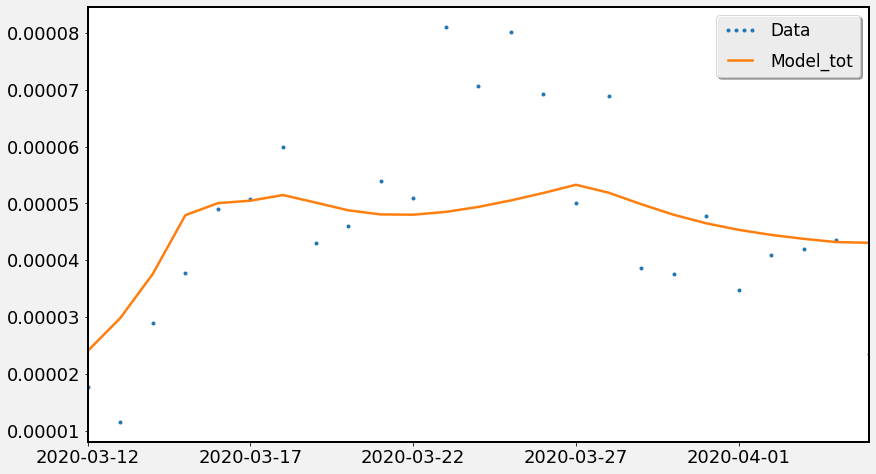

In [10]:
mdl.plot_calibrated_total_model(data=data, mdl_data=res_mdl, date_list=date_lst, 
                            start='2020-03-12', end='2020-04-05')

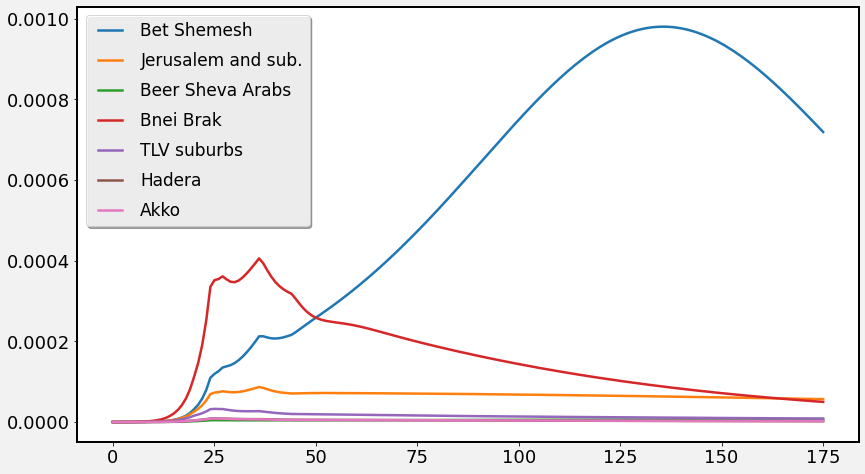

In [19]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.region_name[region]] = (res_mdl['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

In [15]:
res_mdl['new_Is'].sum()

0.015901764064386696

In [ ]:
ven_proba = pd.read_csv('Data/vent_proba.csv')
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.region_name[region]] = (res_mdl['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

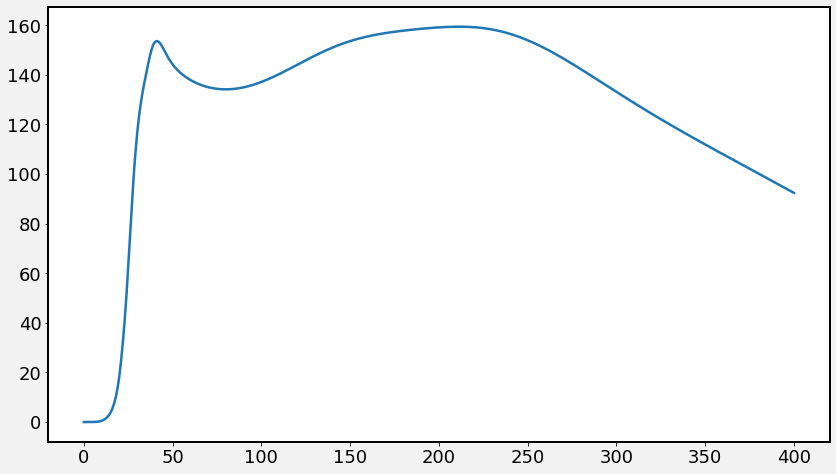

In [14]:
plt.plot((res_mdl['H'].sum(axis=1))*9136000)

In [16]:
(res_mdl['H'].sum(axis=1))[56]*9136000

139.85616268520099

In [17]:
((res_mdl['Is'][:, mdl.age_dict['70+']].sum(axis=1))[56]+(res_mdl['Is'][:, mdl.age_dict['60-69']].sum(axis=1))[56])/(res_mdl['Is'][:].sum(axis=1))[56]

0.19352028004453542

In [18]:
(res_mdl['R'].sum(axis=1))[56]*9136000*0.3

8920.626073952297

### Data with variance

In [19]:
start_idx = int(np.where(date_lst == '2020-03-12')[0])
end_idx = int(np.where(date_lst == '2020-04-05')[0])

In [26]:
model_by_age_region = {}
for i, key in enumerate(mdl.region_age_dict.keys()):
    model_by_age_region[key[0] + '_' + key[1] + '_mdl'] = res_mdl['new_Is'][start_idx:end_idx+1, mdl.region_age_dict[key]].sum(axis=1)
model_by_age_region = pd.DataFrame.from_dict(model_by_age_region)

In [27]:
# Calculating model variance:
std = np.sqrt((np.power(data.values - model_by_age_region.values,2).sum())/(data.values.size - 1))

In [28]:
std

2.542541093307999e-07

### Upper bound calibration

In [ ]:
# minimized value: -25.112767900678186
# Fitted parameters:
#  Beta=[0.03030602 0.05262323 0.06149524 0.2050433 ]
#  Theta=2.328913039368483,
#  Beta_behave=0.5297713948054046
# num of sampling the target function: 173

In [29]:
# Calculating data with adding std
ub_data = data + 2*std

In [3]:
# fit params
days_in_season_ub=70
alpha_ub=1
date_lst = pd.date_range('2020-02-20','2020-04-13')

In [31]:
# Model Fitting
p0=(0.06862921,0.07089788,0.08567678,0.3,1.5103006972556037, 0.4293725726208387) # initial guess
bnds = ((0,0.1),(0,0.15),(0,0.15),(0,0.6),(1,3),(0,1))# boundries for variables
# errorfunc(tpl,data,f,season_length, eps, alpha)
res_fit_ub= optimize.minimize(mdl.errorfunc_by_sector_behavior,p0,bounds=bnds,method='TNC',args=(ub_data.values,mdl.f0_full['Scenario2'],
                                                                           days_in_season_ub,mdl.eps_sector['Scenario2'],alpha_ub,date_lst,
                                                                                    '2020-03-12-','2020-04-05')
                           ,options={'maxiter':1000})

fitted_params_ub = res_fit_ub.x

# run the fitted model:
fitted_beta_ub = np.array([fitted_params_ub[0], fitted_params_ub[0], fitted_params_ub[0], fitted_params_ub[1], fitted_params_ub[1],\
                        fitted_params_ub[2], fitted_params_ub[2], fitted_params_ub[3], fitted_params_ub[3]])
theta_ub = fitted_params_ub[4]
beta_behave_ub = fitted_params_ub[5]
                        
# print data stat
mdl.print_stat_fit_behave(res_fit_ub)

minimized value: -24.050377053060725
Fitted parameters:
 Beta=[0.06872524 0.07058089 0.0849962  0.35823708]
 Theta=1.5147969877267358,
 Beta_behave=0.4195811609779443
num of sampling the target function: 156


In [4]:
# best fit results:
beta_j_ub=np.array([0.06872524,0.06872524,0.06872524,0.07058089,0.07058089,0.0849962,0.0849962,0.35823708,0.35823708])
theta_ub=1.5147969877267358
beta_behave_ub=0.4195811609779443

In [5]:
res_mdl_ub = mdl.run_sector_model_behavior(beta_home=0.38/9., theta=theta_ub, beta_j=beta_j_ub, beta_behave=beta_behave_ub,
                                        eps=mdl.eps_sector['Scenario2'], f=mdl.f0_full['Scenario2'], alpha=alpha_ub, 
                                        days_in_season=175,new=1./10.)

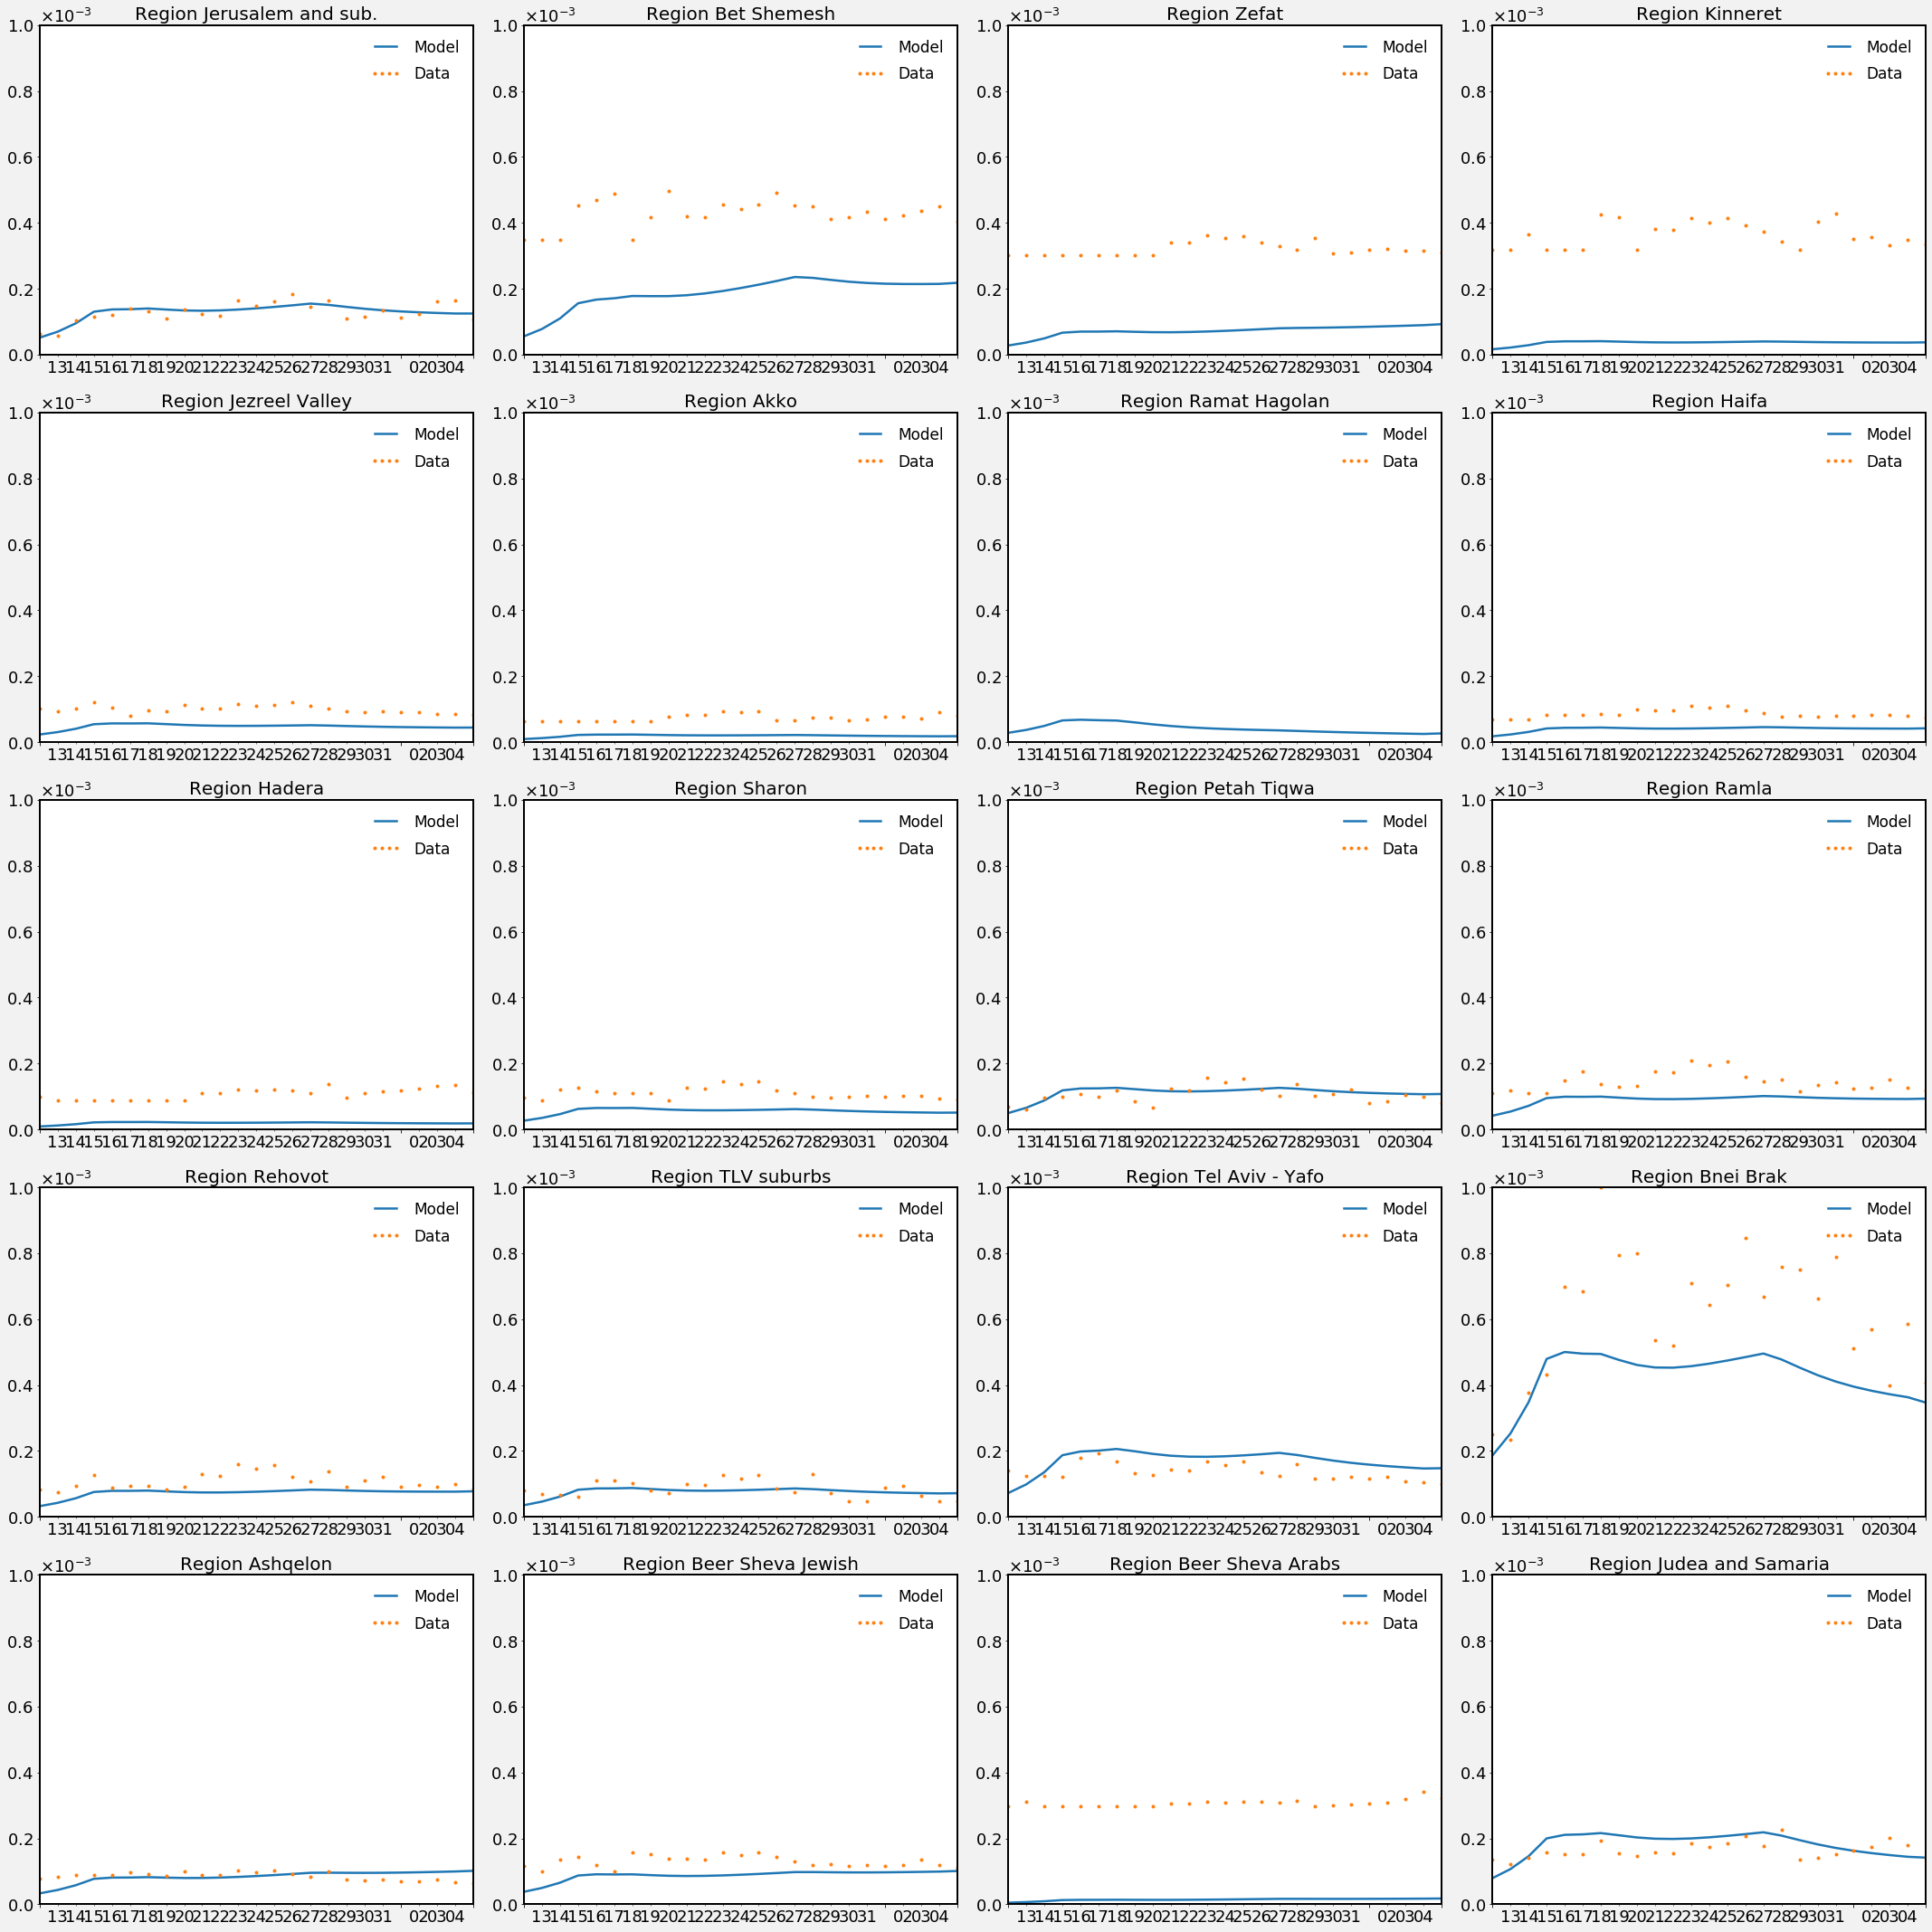

In [33]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=ub_data.values, mdl_data = res_mdl_ub['new_Is'],date_list = date_lst,
                                         start='2020-03-12',end='2020-04-05')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

In [11]:
mdl.plot_calibrated_total_model(data=ub_data, mdl_data=res_mdl_ub, date_list=date_lst, 
                            start='2020-03-12', end='2020-04-05')

NameError: name 'ub_data' is not defined

In [35]:
res_mdl_ub['new_Is'].sum()

0.04792615860434173

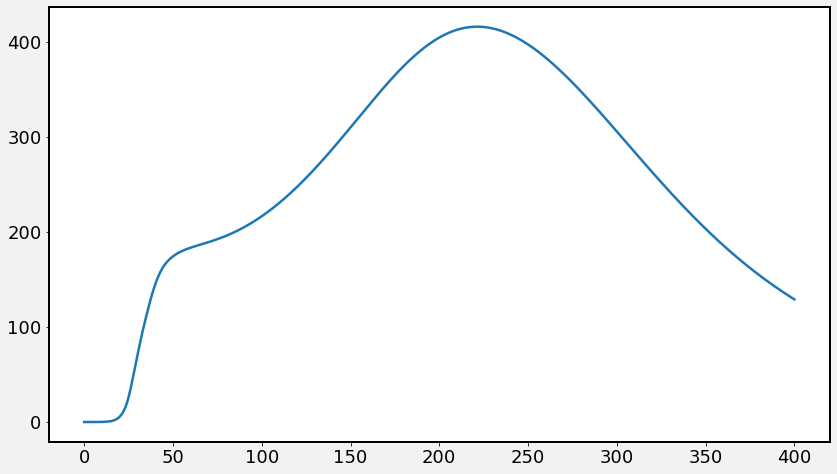

In [6]:
plt.plot((res_mdl_ub['H'].sum(axis=1))*9136000)

### Lower bound

In [47]:
# Calculating data with adding std
lb_data = data*0.5

In [3]:
# fit params
days_in_season_lb=70
alpha_lb=1
date_lst = pd.date_range('2020-02-20','2020-04-13')

In [48]:
# Model Fitting
p0=(0.06862921,0.07089788,0.08567678,0.3,1.5103006972556037, 0.4293725726208387) # initial guess
bnds = ((0,0.1),(0,0.15),(0,0.15),(0,0.6),(1,3),(0,1))# boundries for variables
# errorfunc(tpl,data,f,season_length, eps, alpha)
res_fit_lb= optimize.minimize(mdl.errorfunc_by_sector_behavior,p0,bounds=bnds,method='TNC',args=(lb_data.values,mdl.f0_full['Scenario2'],
                                                                           days_in_season_ub,mdl.eps_sector['Scenario2'],alpha_ub,date_lst,
                                                                                    '2020-03-12-','2020-04-05')
                           ,options={'maxiter':1000})

fitted_params_lb = res_fit_lb.x

# run the fitted model:
fitted_beta_lb = np.array([fitted_params_lb[0], fitted_params_lb[0], fitted_params_lb[0], fitted_params_lb[1], fitted_params_lb[1],\
                        fitted_params_lb[2], fitted_params_lb[2], fitted_params_lb[3], fitted_params_lb[3]])
theta_lb = fitted_params_lb[4]
beta_behave_lb = fitted_params_lb[5]
                        
# print data stat
mdl.print_stat_fit_behave(res_fit_lb)

minimized value: -26.594874666871632
Fitted parameters:
 Beta=[0.01684003 0.03004164 0.03680587 0.11561031]
 Theta=3.0,
 Beta_behave=0.8029761250996457
num of sampling the target function: 426


In [4]:
# best fit results:
beta_j_lb=np.array([0.01684003,0.01684003,0.01684003,0.03004164,0.03004164,0.03680587,0.03680587,0.11561031,0.11561031])
theta_lb=3.0
beta_behave_lb=0.8029761250996457

In [5]:
res_mdl_lb = mdl.run_sector_model_behavior(beta_home=0.38/9., theta=theta_lb, beta_j=beta_j_lb, beta_behave=beta_behave_lb,
                                        eps=mdl.eps_sector['Scenario2'], f=mdl.f0_full['Scenario2'], alpha=alpha_lb, 
                                        days_in_season=175,new=1./10.)

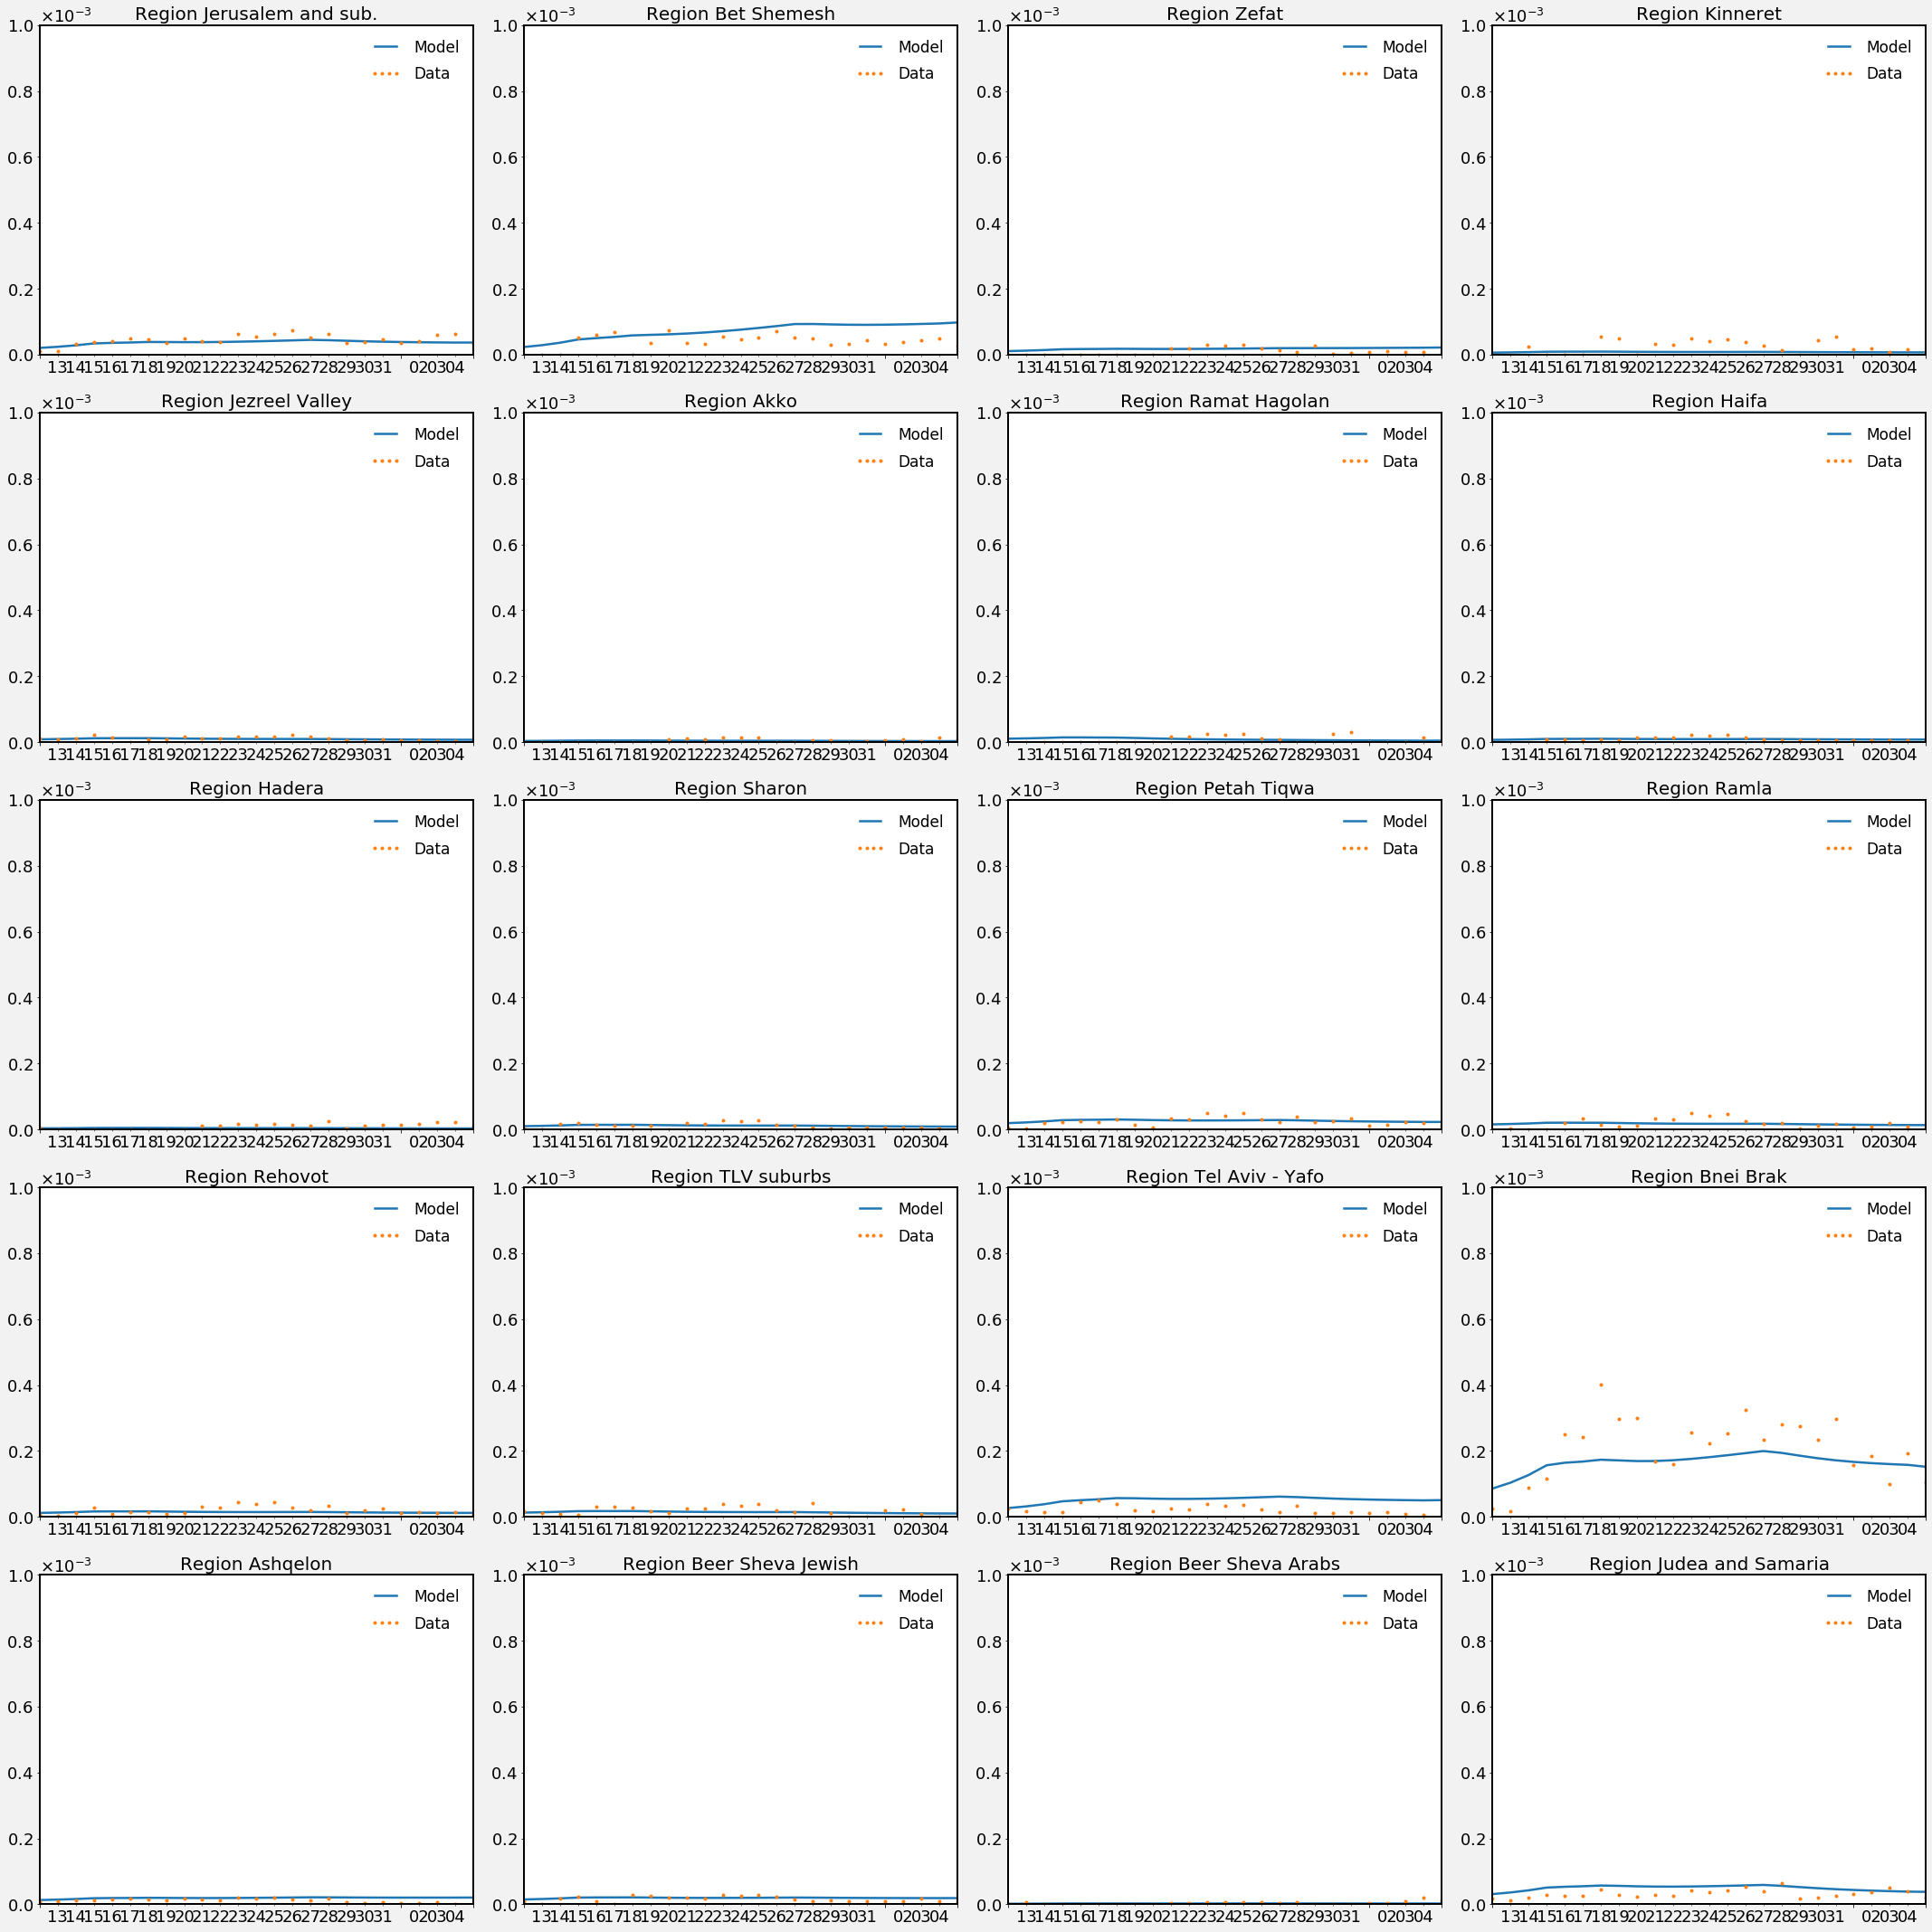

In [50]:
# plotting the data and model
fig,ax = mdl.plot_calibrated_model_region(data=lb_data.values, mdl_data = res_mdl_lb['new_Is'],date_list = date_lst,
                                         start='2020-03-12',end='2020-04-05')
fig.set_size_inches((30,30))
plt.tight_layout()
plt.show()

(<Figure size 1008x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1434be59f28>)

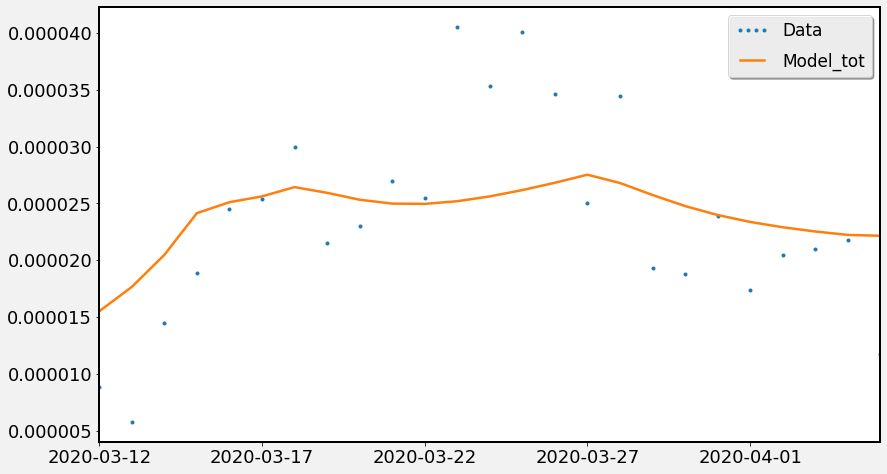

In [51]:
mdl.plot_calibrated_total_model(data=lb_data, mdl_data=res_mdl_lb, date_list=date_lst, 
                            start='2020-03-12', end='2020-04-05')

In [35]:
res_mdl_ub['new_Is'].sum()

0.04792615860434173

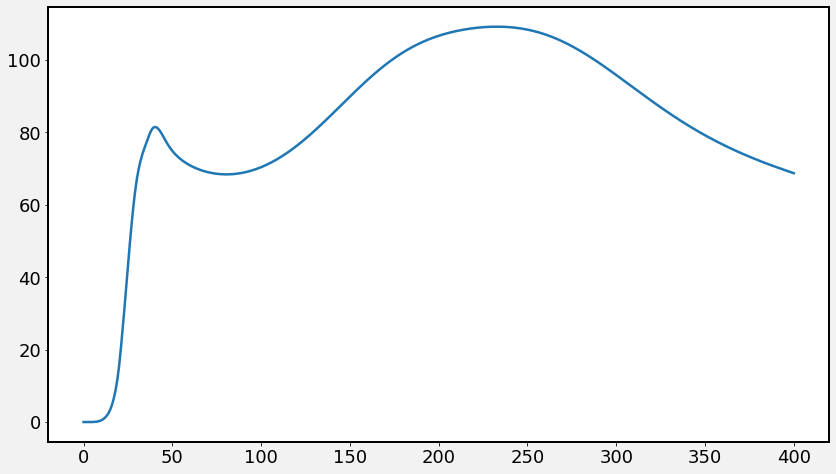

In [16]:
plt.plot((res_mdl_lb['H'].sum(axis=1))*9136000)

# 60+ in Quarantine

In [6]:
inter_age = mdl.get_opposite_dict(mdl.N,list(itertools.product(mdl.M.values(), mdl.A.values())))

In [7]:
inter_age.keys()

dict_keys([('Intervention', '0-4'), ('Intervention', '5-9'), ('Intervention', '10-19'), ('Intervention', '20-29'), ('Intervention', '30-39'), ('Intervention', '40-49'), ('Intervention', '50-59'), ('Intervention', '60-69'), ('Intervention', '70+'), ('Non-intervention', '0-4'), ('Non-intervention', '5-9'), ('Non-intervention', '10-19'), ('Non-intervention', '20-29'), ('Non-intervention', '30-39'), ('Non-intervention', '40-49'), ('Non-intervention', '50-59'), ('Non-intervention', '60-69'), ('Non-intervention', '70+')])

In [7]:
# age_lst = ['0-4']
age_lst = ['0-4','5-9','10-19','20-29','30-39','40-49','50-59']

In [8]:
# new S
init_pop = res_mdl_lb['S'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_pop[inter_age['Intervention',age]] = init_pop[inter_age['Non-intervention',age]]
        init_pop[inter_age['Non-intervention',age]] = 0

In [9]:
# new E
init_E = res_mdl_lb['E'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_E[inter_age['Intervention',age]] = init_E[inter_age['Non-intervention',age]]
        init_E[inter_age['Non-intervention',age]] = 0

In [10]:
# new Ie
init_Ie = res_mdl_lb['Ie'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_Ie[inter_age['Intervention',age]] = init_Ie[inter_age['Non-intervention',age]]
        init_Ie[inter_age['Non-intervention',age]] = 0

In [11]:
#new Is
init_Is = res_mdl_lb['Is'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_Is[inter_age['Intervention',age]] = init_Is[inter_age['Non-intervention',age]]
        init_Is[inter_age['Non-intervention',age]] = 0

In [12]:
#new Ia
init_Ia = res_mdl_lb['Ia'][56,:].copy()
for age in mdl.A.values():
#     if age not in ['60-69','70+']:
    if age  in age_lst:
        init_Ia[inter_age['Intervention',age]] = init_Ia[inter_age['Non-intervention',age]]
        init_Ia[inter_age['Non-intervention',age]] = 0

In [13]:
with open('Data/parameters/C_quarantine_60_70.pickle', 'rb') as pickle_in:
    C = pickle.load(pickle_in)

In [14]:
res_mdl_60_70 = mdl.continue_run_sector_model_behavior(model_res=res_mdl_lb,t_start=56,intervention=True,C=C,
                                  beta_home=0.38/9., theta=1.0, beta_j=beta_j_lb, beta_behave=beta_behave_lb,
                                        eps=mdl.eps_sector['Scenario2'], f=mdl.f0_full['Scenario2'], alpha=alpha_lb, 
                                        days_in_season=120, new=1/10., new_pop_dist=init_pop, new_E=init_E, new_I_e=init_Ie,
                                                      new_I_s=init_Is, new_I_a=init_Ia)

In [15]:
res_mdl_60_70['new_Is'].sum()

0.3216035651029858

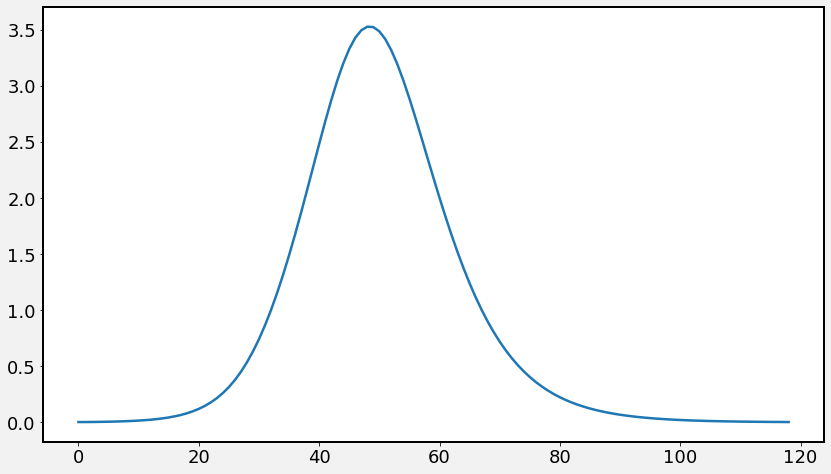

In [24]:
plt.plot(res_mdl_60_70['L'][:,mdl.age_ga_dict['50-59']].sum(axis=1))

In [46]:
res_mdl_60_70['L'][:,mdl.age_ga_dict['70+']].sum(axis=0)

array([2.7822938057688567, 10.090682276505333, 2.3630754192621497,
       2.0758851984796114, 2.022659989724443, 2.1463613489194797,
       1.9562127270101466, 1.0547903837229198, 1.9094703818715446,
       1.480017136347956, 1.6545384143004904, 1.945172818461262,
       1.3708231864985674, 0.9558232479351321, 0.6031561584801624,
       11.05951949352481, 1.678195159857887, 1.618420243526544,
       10.338985332775621, 6.650471081271031], dtype=object)

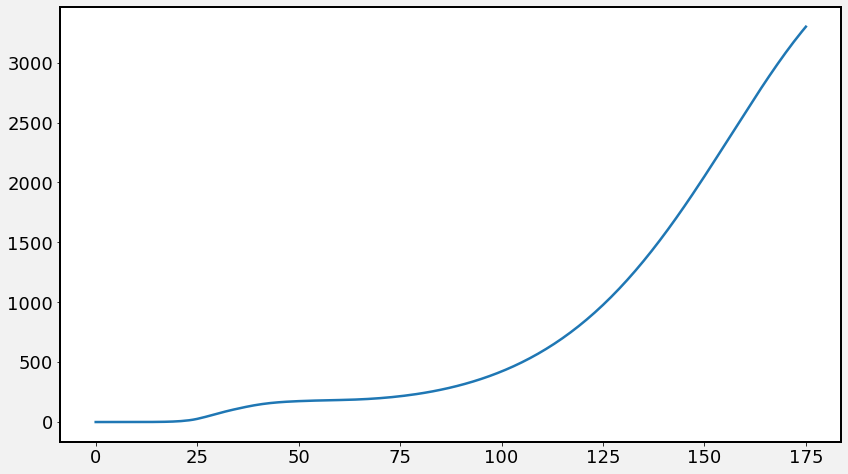

In [15]:
plt.plot((res_mdl_60_70['H'].sum(axis=1)[:])*9136000)

In [16]:
# Save
with open('Data/parameters/low_60_70.pickle', 'wb') as handle:
    pickle.dump(res_mdl_60_70, handle, protocol=pickle.HIGHEST_PROTOCOL)

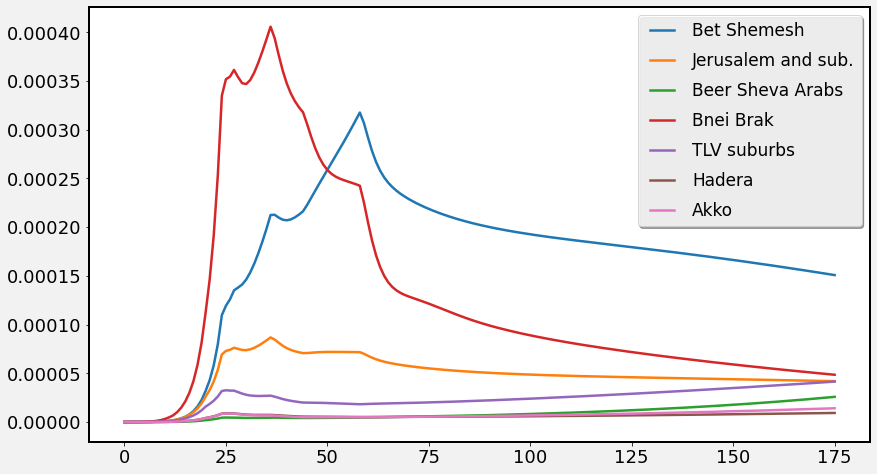

In [18]:
# Creating table 1, by region:
tabel_1_dict = {}
for region in ['11_betshemesh','11','62_arab','51_bb','51','32','24']:
    tabel_1_dict[mdl.region_name[region]] = (res_mdl_60_70['new_Is'][:, mdl.region_dict[region]].sum(axis=1))/mdl.population_size[mdl.region_dict[region]].sum()
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

tabel1_df.iloc[:].plot()

# Data for dashboard

In [27]:
with open('Data/parameters/low_60_70.pickle', 'rb') as pickle_in:
    res_low = pickle.load(pickle_in)

with open('Data/parameters/high_60_70.pickle', 'rb') as pickle_in:
    res_high = pickle.load(pickle_in)
    
with open('Data/parameters/normal_60_70.pickle', 'rb') as pickle_in:
    res_normal = pickle.load(pickle_in)

In [28]:
date_rang = pd.date_range('2020-02-20', periods=176, freq='d')

In [29]:
age_dist_area = pd.read_csv('../Data/demograph/age_dist_area.csv',index_col=0).iloc[0:20][['0-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']].copy()
age_dist_area = age_dist_area.sum(axis=1)

In [30]:
tot_I = res_normal['Is'] + res_normal['Ia']
tot_I_ub = res_high['Is'] + res_high['Ia']
tot_I_lb = res_low['Is'] + res_low['Ia']

In [31]:
# tabel 1, coloring the map
# Creating table 1, by region:
tabel_1_dict = {}
tabel_1_dict['date'] = date_rang
for region in mdl.region_dict.keys():
    tabel_1_dict[mdl.region_name[region]] = (tot_I[:, mdl.region_dict[region]].sum(axis=1))/age_dist_area[region]
tabel1_df = pd.DataFrame.from_dict(tabel_1_dict)

In [32]:
# 'daysoffset' will container the weekday, as integers
tabel1_df['daysoffset'] = tabel1_df['date'].apply(lambda x: x.weekday())
# We apply, row by row (axis=1) a timedelta operation
tabel1_df['week_start'] = tabel1_df.apply(lambda x: x['date'] - dt.timedelta(days=x['daysoffset']), axis=1)

In [33]:
tab1_groupped = tabel1_df.groupby('week_start')[list(mdl.region_name.values())]
tab1_groupped = tab1_groupped.apply(lambda x: (x.max() + x.min())/2)

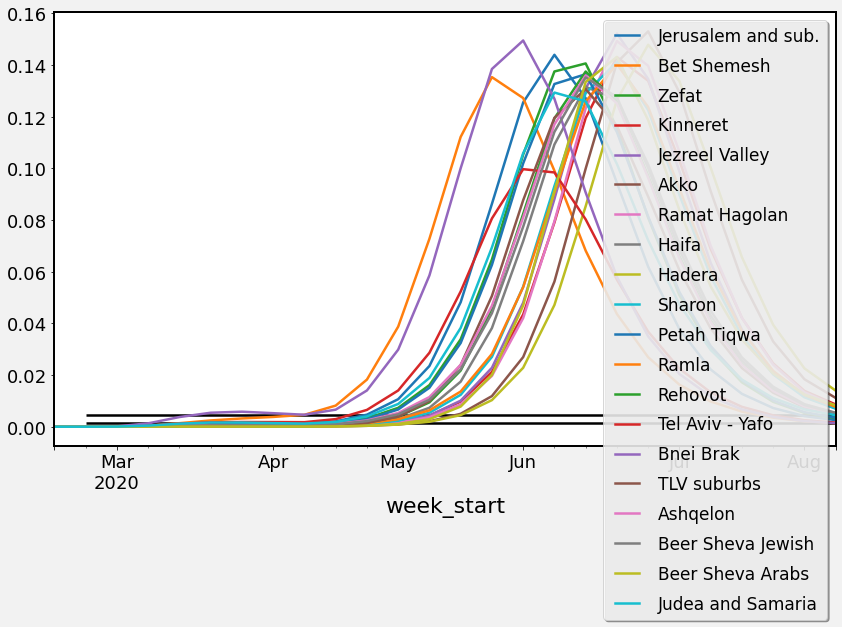

In [34]:
tab1_groupped[list(mdl.region_name.values())].plot()
plt.hlines(xmin='2020-02-20',xmax='2020-09-30', y=0.0045)
plt.hlines(xmin='2020-02-20',xmax='2020-09-30', y=0.0013)

In [35]:
tab1_groupped.loc['2020-04-17':'2020-06-17'].stack()

week_start                    
2020-04-20  Jerusalem and sub.    0.002043
            Bet Shemesh           0.008170
            Zefat                 0.001444
            Kinneret              0.000369
            Jezreel Valley        0.000326
                                    ...   
2020-06-15  TLV suburbs           0.130734
            Ashqelon              0.135986
            Beer Sheva Jewish     0.135187
            Beer Sheva Arabs      0.133438
            Judea and Samaria     0.125941
Length: 180, dtype: float64

In [36]:
# Saving table_1:
tab1_groupped.loc['2020-04-17':'2020-06-17'].stack().to_csv('Incidence_per_region_60_70.csv')

In [35]:
# Age groups

In [37]:
tabel_2 = pd.DataFrame(index = pd.MultiIndex.from_tuples(itertools.product(date_rang, mdl.A.values()),names=['date','age']), 
                                     columns=['mean','UB','LB'])

In [38]:
# fill the matrix:
for index in list(tabel_2.index):
#     print(int(np.where(date_rang == index[0])[0]))
    tabel_2.loc[index,'mean'] = tot_I[int(np.where(date_rang == index[0])[0]),mdl.age_dict[index[1]]].sum()
    tabel_2.loc[index,'UB'] = tot_I_ub[int(np.where(date_rang == index[0])[0]),mdl.age_dict[index[1]]].sum()
    tabel_2.loc[index,'LB'] = tot_I_lb[int(np.where(date_rang == index[0])[0]),mdl.age_dict[index[1]]].sum()

In [39]:
# 'daysoffset' will container the weekday, as integers
tabel_2['daysoffset'] = tabel_2.apply(lambda x: x.name[0].weekday(),axis=1)
# We apply, row by row (axis=1) a timedelta operation
tabel_2['week_start'] = tabel_2.apply(lambda x: x.name[0] - dt.timedelta(days=x['daysoffset']), axis=1)

In [40]:
tabel_2.reset_index(inplace=True)

In [41]:
tabel_2_groupped = tabel_2.groupby(['week_start','age'])[['mean','UB','LB']]
tabel_2_groupped = tabel_2_groupped.apply(lambda x: (x.max() + x.min())/2) * 9136000

In [42]:
tabel_2_groupped['mean'] = tabel_2_groupped['mean'].apply(np.ceil)
tabel_2_groupped['UB'] = tabel_2_groupped['UB'].apply(np.ceil)
tabel_2_groupped['LB'] = tabel_2_groupped['LB'].apply(np.ceil)

In [43]:
tabel_2_groupped.reset_index(inplace=True)

In [44]:
tabel_2_groupped[tabel_2_groupped.week_start == '2020-06-15']

,week_start,age,mean,UB,LB
153,2020-06-15,0-4,82171.0,110190.0,71008.0
154,2020-06-15,10-19,182249.0,161255.0,152613.0
155,2020-06-15,20-29,194272.0,129588.0,177209.0
156,2020-06-15,30-39,166215.0,130322.0,149138.0
157,2020-06-15,40-49,164289.0,99583.0,169218.0
158,2020-06-15,5-9,78422.0,100826.0,66487.0
159,2020-06-15,50-59,108290.0,99466.0,89764.0
160,2020-06-15,60-69,94797.0,82382.0,78314.0
161,2020-06-15,70+,49238.0,71124.0,38782.0


In [45]:
tabel_2_groupped[(tabel_2_groupped.week_start>'2020-04-16')&(tabel_2_groupped.week_start<'2020-06-16')].to_csv('bar_plot_model_60_70.csv')

In [ ]:
# ventilators

In [47]:
vents_dict['mean'][55]

133.0

In [46]:
vents_dict = {}
vents_dict['date'] = date_rang
vents_dict['mean'] = np.ceil(res_normal['H'].sum(axis=1) * 9136000)+53
vents_dict['UB'] = np.ceil(res_high['H'].sum(axis=1) * 9136000)+53
vents_dict['LB'] = np.ceil(res_low['H'].sum(axis=1) * 9136000)+53
vents_df = pd.DataFrame.from_dict(vents_dict)

In [48]:
# 'daysoffset' will container the weekday, as integers
vents_df['daysoffset'] = vents_df['date'].apply(lambda x: x.weekday())
# We apply, row by row (axis=1) a timedelta operation
vents_df['week_start'] = vents_df.apply(lambda x: x['date'] - dt.timedelta(days=x['daysoffset']), axis=1)

In [49]:
vents_df_grop = vents_df.groupby('week_start')[['mean','UB','LB']]
vents_df_grop = vents_df_grop.max()

In [51]:
vents_df_grop['2020-04-16':'2020-06-16'].to_csv('ventilators_60_70.csv')